### https://www.coursera.org/learn/data-analysis-applications/supplement/QNH2F/primier-postroieniia-proghnoza-ipython-notebook

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


                 y
ds                
2009-10-01  338630
2009-11-01  339386
2009-12-01  400264
2010-01-01  314640
2010-02-01  311022


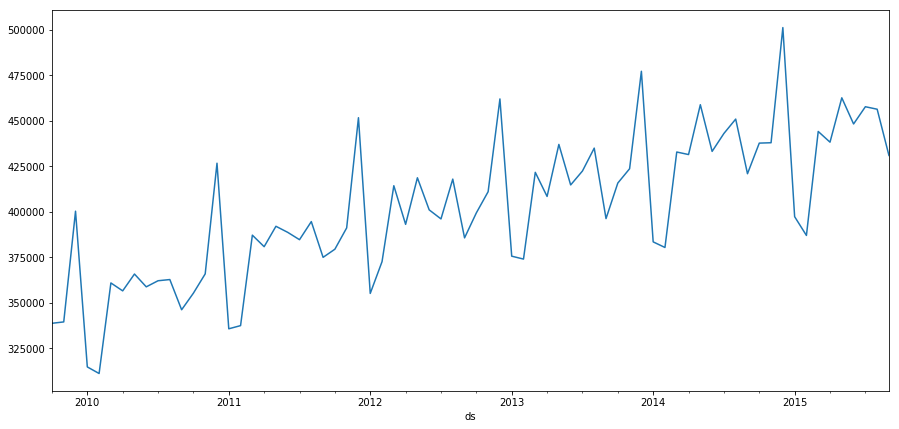

In [2]:
df = pd.read_csv('sales.csv',',', index_col=['ds'], parse_dates=['ds'], dayfirst=True)
print(df.head())
plt.figure(figsize(15,7))
df.y.plot()
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.000372


<Figure size 1080x720 with 0 Axes>

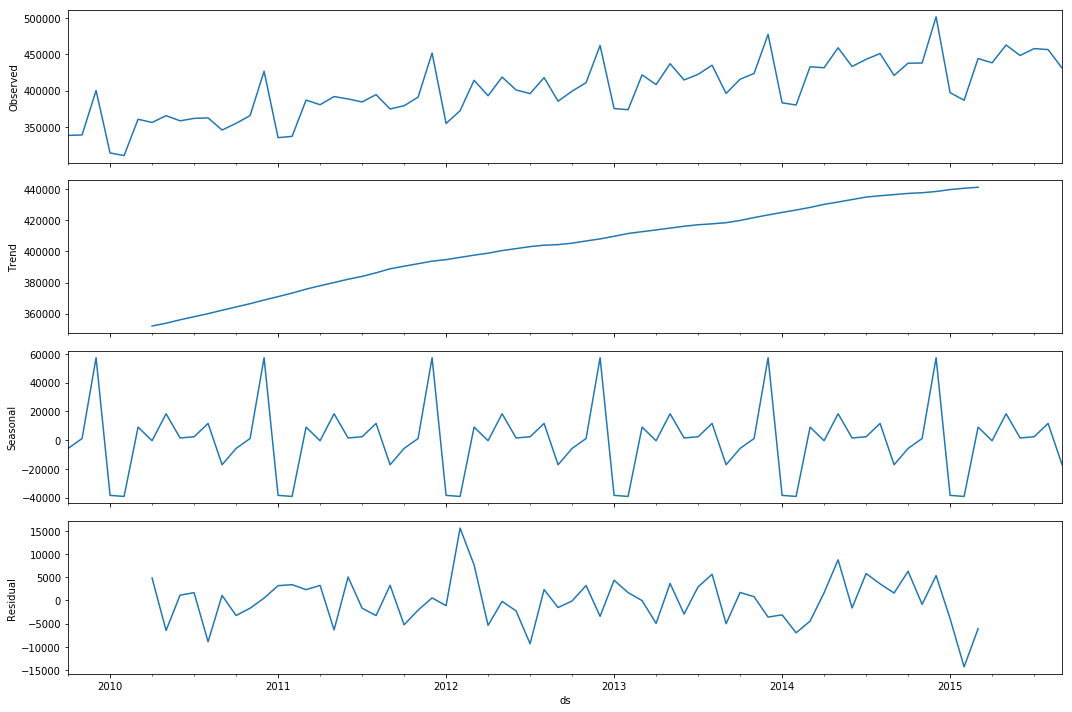

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.y).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y)[1])

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 1.067897
Критерий Дики-Фуллера: p=0.000529


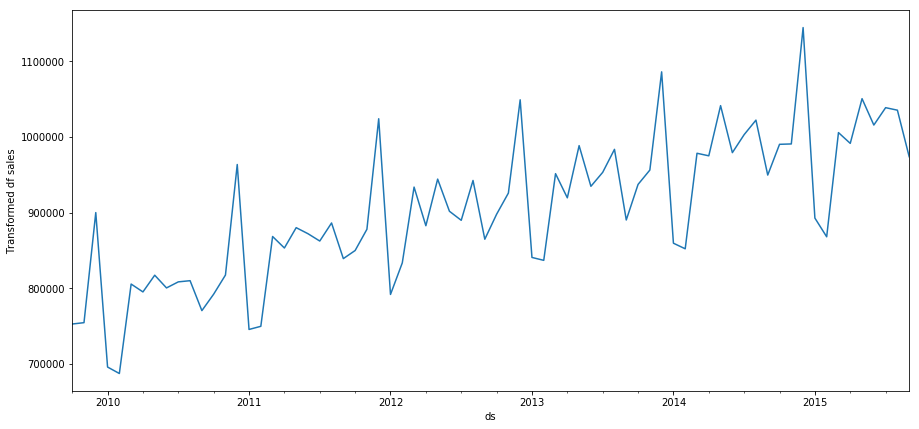

In [4]:
df['y_box'], lmbda = stats.boxcox(df.y)
plt.figure(figsize(15,7))
df.y_box.plot()
plt.ylabel(u'Transformed df sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_box)[1])

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.270565


<Figure size 1080x720 with 0 Axes>

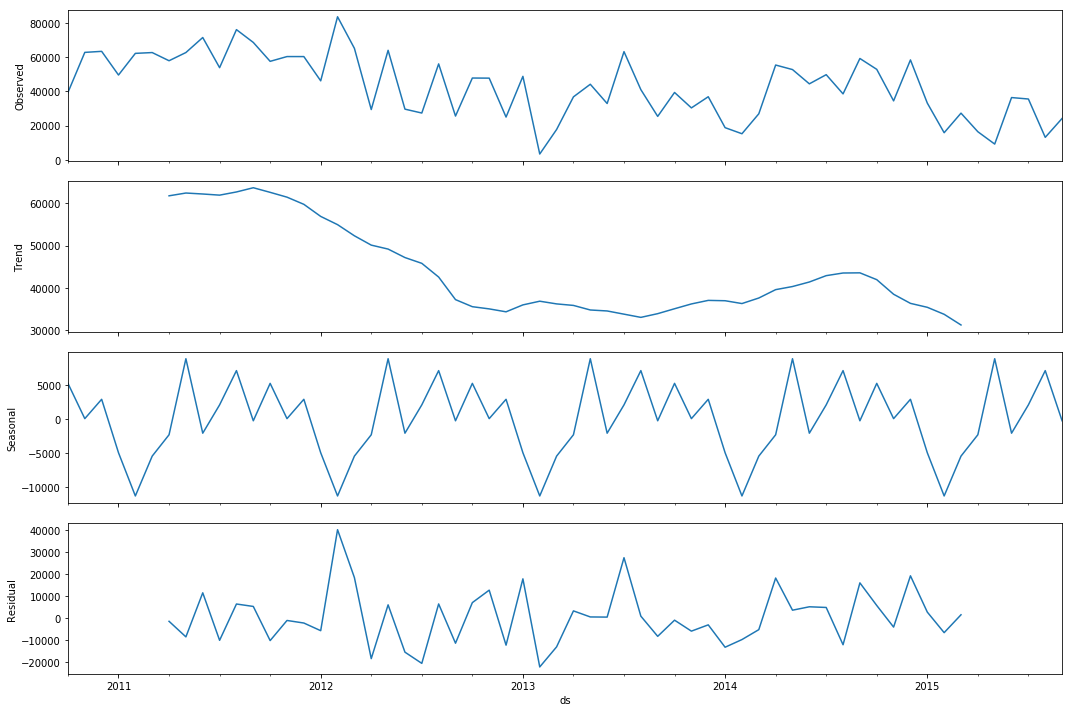

In [5]:
df['y_box_diff'] = df.y_box - df.y_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.y_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000016


<Figure size 1080x720 with 0 Axes>

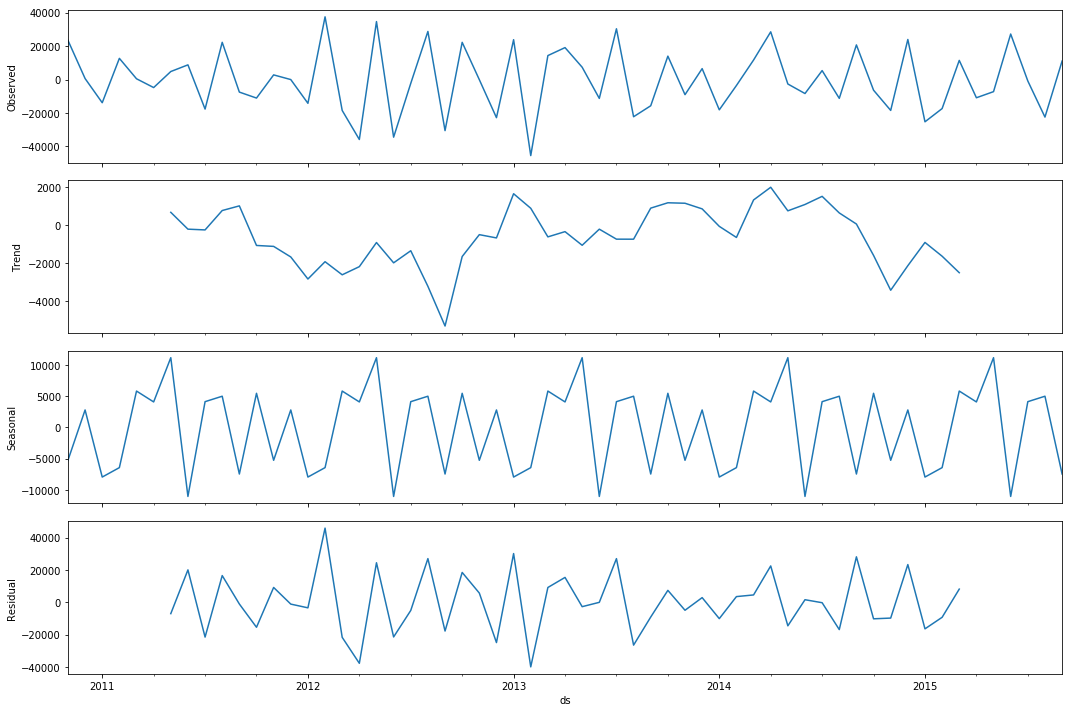

In [6]:
df['y_box_diff2'] = df.y_box_diff - df.y_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.y_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

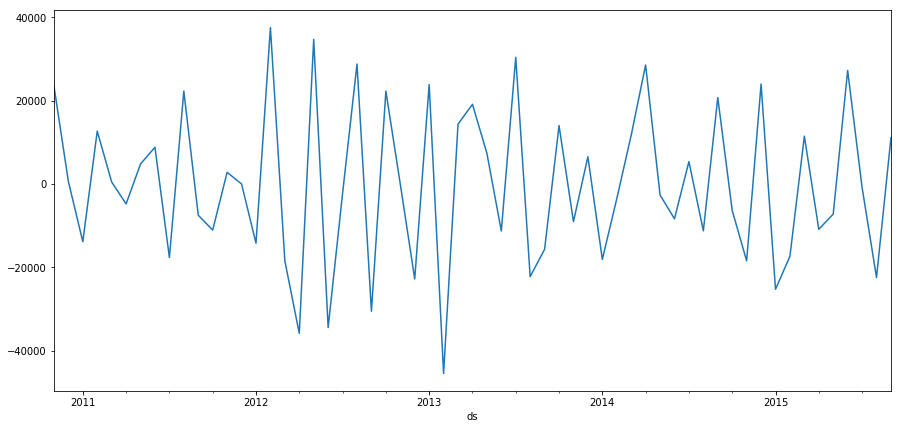

In [7]:
plt.figure(figsize(15,7))
df.dropna().y_box_diff2.plot()

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

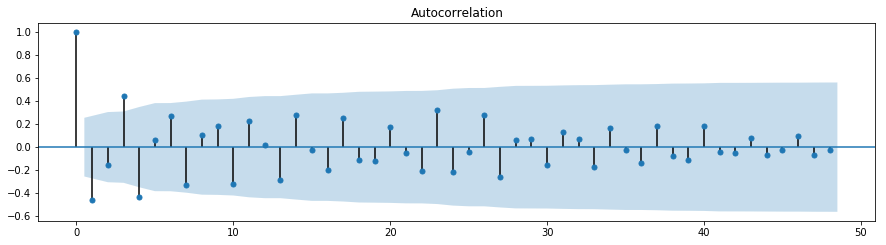

/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


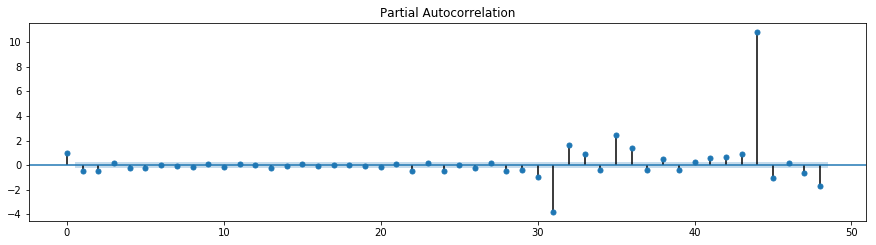

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.y_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.y_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=4, P=2, p=11

In [9]:
from statsmodels.tsa.ar_model import AR

#create train/test datasets
X = df.y_box_diff2.dropna()

#train the autoregression model
model = AR(X)
model_fitted = model.fit()

print('The lag value chose is: %s' % model_fitted.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted.params)

The lag value chose is: 11
The coefficients of the model are:
 const             -3133.606680
L1.y_box_diff2       -0.598275
L2.y_box_diff2       -0.445745
L3.y_box_diff2       -0.142507
L4.y_box_diff2       -0.467785
L5.y_box_diff2       -0.264634
L6.y_box_diff2       -0.150967
L7.y_box_diff2       -0.154520
L8.y_box_diff2       -0.167189
L9.y_box_diff2       -0.026684
L10.y_box_diff2      -0.122351
L11.y_box_diff2       0.001106
dtype: float64


/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [10]:
ps = range(0, 12)
d=1
qs = range(0, 5)
Ps = range(0, 3)
D=1
Qs = range(0, 1)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [12]:
# %%time
# results = []
# best_aic = float("inf")
# warnings.filterwarnings('ignore')
# 
# for param in parameters_list:
#     #try except нужен, потому что на некоторых наборах параметров модель не обучается
#     try:
#         model=sm.tsa.statespace.SARIMAX(df.y_box, order=(param[0], d, param[1]), 
#                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#     #выводим параметры, на которых модель не обучается и переходим к следующему набору
#     except Exception:
#         print('wrong parameters:', param)
#         continue
#     aic = model.aic
#     #сохраняем лучшую модель, aic, параметры
#     if aic < best_aic:
#         best_model = model
#         best_aic = aic
#         best_param = param
#     results.append([param, model.aic])
# 
# warnings.filterwarnings('default')

In [13]:
# %%time
# from pmdarima import auto_arima
# arima_model = auto_arima(df.y_box, seasonal=True, m=12, error_action='ignore')
# print(arima_model.summary())

In [14]:
# print(sm.tsa.statespace.SARIMAX(df.y_box, order=(3, d, 2), 
#                                         seasonal_order=(0, D, 0, 12)).fit(disp=-1).aic)
# print(best_model.aic)

Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [15]:
# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

Лучшая модель:

In [16]:
best_model = sm.tsa.statespace.SARIMAX(df.y_box, order=(2, d, 3), 
                                        seasonal_order=(1, D, 0, 12)).fit(disp=-1)
print(best_model.summary())

/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              y_box   No. Observations:                   72
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -646.592
Date:                            Thu, 29 Aug 2019   AIC                           1307.184
Time:                                    22:13:55   BIC                           1321.727
Sample:                                10-01-2009   HQIC                          1312.861
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1671      0.024    -47.875      0.000      -1.215      -1.119
ar.L2         -0.9985      0.020   

Её остатки:

Критерий Стьюдента: p=0.562942
Критерий Дики-Фуллера: p=0.000000


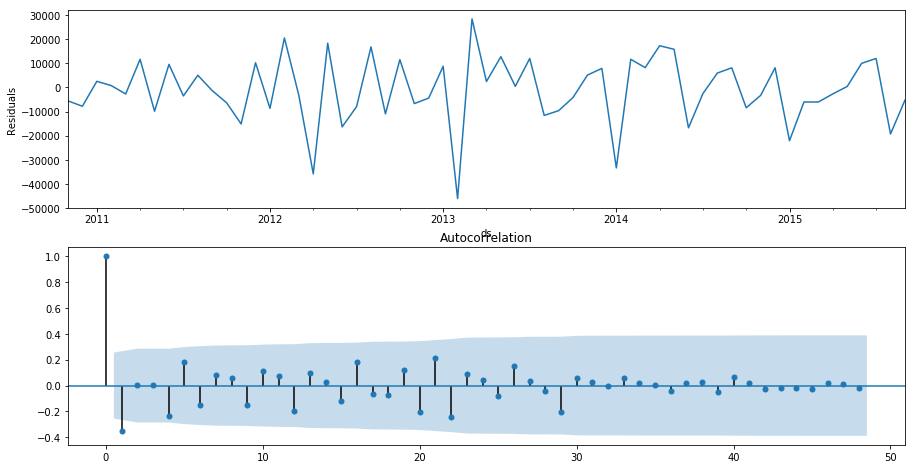

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

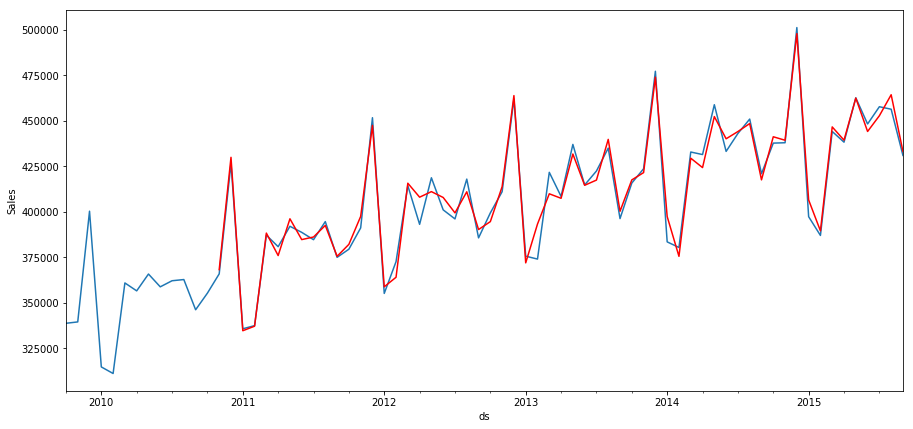

In [18]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.y.plot()
df.model[13:].plot(color='r')
plt.ylabel('Sales')
pylab.show()

### Прогноз

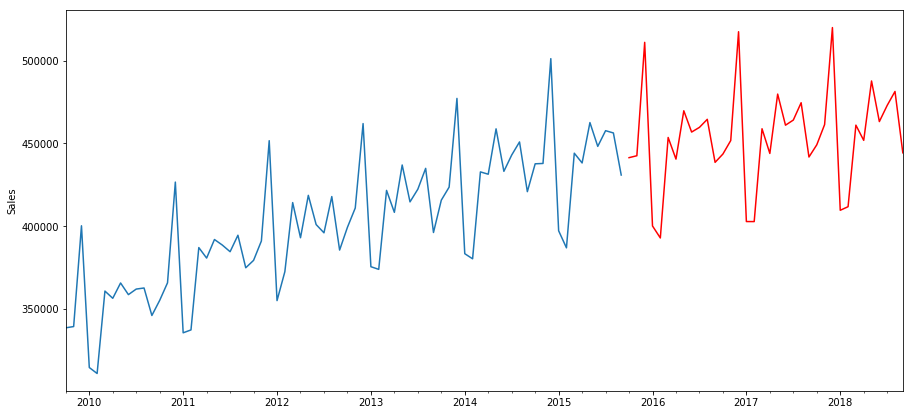

In [19]:
df2 = df[['y']]
date_list = [datetime.datetime.strptime("2015-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=72, end=107), lmbda)

plt.figure(figsize(15,7))
df2.y.plot()
df2.forecast.plot(color='r')
plt.ylabel('Sales')
pylab.show()

In [20]:
best_model.conf_int(alpha=0.05)

,0,1
ar.L1,-1.214904e+00,-1.119342e+00
ar.L2,-1.037022e+00,-9.599792e-01
ma.L1,8.805446e-01,1.378354e+00
ma.L2,5.679714e-01,1.356020e+00
ma.L3,-1.379873e-01,7.685035e-02
ar.S.L12,-1.024264e-01,8.820896e-02
sigma2,2.305945e+08,2.305945e+08


In [21]:
df_train = df[:-12]
df_test = df[-12:]

df_train['y_box'], lmbda = stats.boxcox(df_train.y)

from pmdarima import auto_arima
arima_model = auto_arima(df_train.y_box, seasonal=True, m=12, error_action='ignore')

/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/kupuk/Projects/Time_Series_Forecasting/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/kupuk/Projects/Time_Series_For

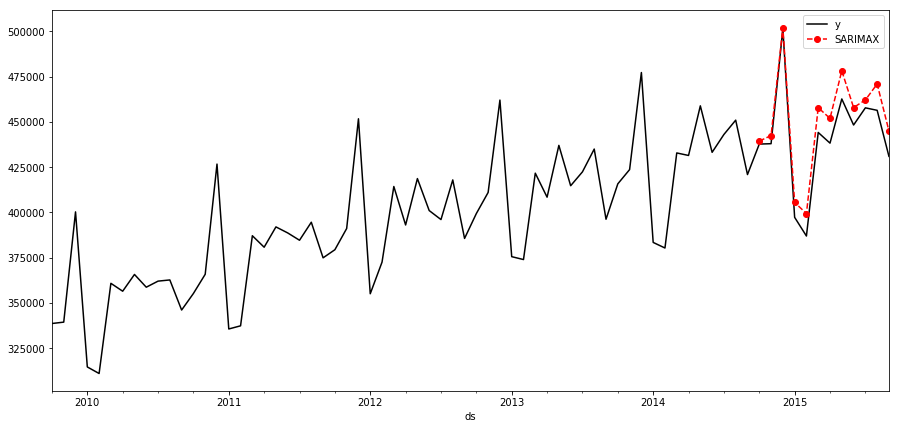

In [22]:
df_r = pd.DataFrame(df_test)
df_r.y = invboxcox(arima_model.predict(12), lmbda)
df_r.rename({'y': 'SARIMAX'}, axis=1, inplace=True)

df.y.plot(color='black', legend=True)
df_r.SARIMAX.plot(style='--', marker='o', color='red', legend=True)


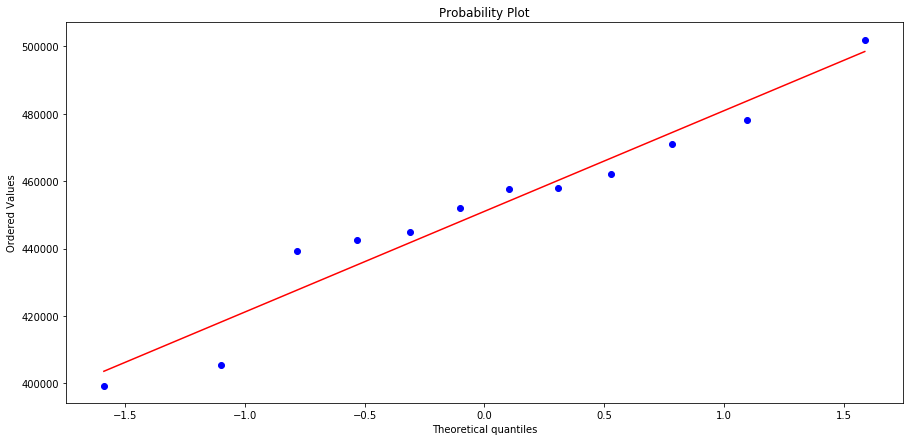

In [23]:
import scipy.stats as stats

measurements = df_r.SARIMAX
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()


In [25]:
print('MAE: {}'.format(np.mean(np.absolute(measurements - df[-12:].y))))
print('MAPE: {}'.format(np.mean(np.absolute(measurements -df[-12:].y)/df[-12:].y)))

MAE: 9422.086217785798
MAPE: 0.021625687804793223
